# Catégoriser automatiquement des questions : OC projet 6 #

## Introduction au projet 6 :  ##

  Notre objectif à travers ce projet sera de batir un moteur de recommendations de tags à partir d'une question posée par un utilisateur de Stack Overflow. Nous extrairons un certain nombre de questions depuis le site afin d'entrainer nos algorithmes et construire notre moteur de recommendations de tags.
  Nous explorerons deux approches:
  - une approche avec des méthodes non supervisées afin d'évaluer la qualité des modèles obtenues.
  - une approch avec des méthodes supervisées de type binary relevance ou multilabel classifieur.

### Contraintes pour notre projet : ###

- Mettre en œuvre une approche non supervisée.
- Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
- Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
- Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple git.

### Livrables attendus : ###

- Un notebook d’exploration comprenant une analyse univariée, une analyse multivariée, une réduction dimensionnelle et les différentes questions de recherches associées (non cleané, pour comprendre votre démarche)
- Un notebook de test de différents modèles (non cleané, pour comprendre votre démarche)
- Le code final à déployer présenté dans un répertoire et développé progressivement à l’aide d’un logiciel de gestion de version (plusieurs commits cohérents)
- Le point d’entrée d’une API disponible pour le test
- Un rapport (en pdf) présentant les différents traitements effectués, et détaillant les modélisations effectuées, en particulier celle qui est en production. 
- La présentation servant de support à la soutenance.

### Ce rapport...: ###


1. montrera vos capacités de synthèse (environ 10 pages).
2. respectera des règles de présentation (plan, sommaire, orthographe, mise en page, titres aux figures, lisibilité des figures).
3. possédera un contenu scientifique : ne pas sur-simplifier (garder les noms des algorithmes, expliquer clairement la démarche).


## Importations des librairies python: ##

Dans ce projet, nous utiliserons notamment:
- la bibliothèque standard nltk afin de traiter les données textuelle de notre jeu de données.
- la biblithèque sklearn pour les algorithmes de machine learning utilisés.
- bs4 pour le nettoyage des données (balises html).
- la bibliothèque wordcloud afin de visualiser sous format graphique des nuages de mots.
- pyLDAvis pour la visualisation des résultats de la LatentDirichletAllocation, approche non supervisée que nous utiliserons dans une première modélisation.

In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

import datetime
from datetime import datetime

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import pyLDAvis
import pyLDAvis.sklearn

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from IPython.core.display import Image, display

import auxiliary as aux


## Définitions des fonctions utilisées dans ce notebook : ##

In [3]:
def line_treatment(line, list_words, tokenizer):
    """ Fonction qui traite une liste de mots en entrée
    et ressort un bag of words avec RegexTokenizer
    """
    list_to_include = []
    list_to_drop = []
    line = line.lower()
    for mot in list_words:
        if(mot in line.lower()):
            list_to_include.append(mot)
            list_to_drop.append(tokenizer.tokenize(mot)[0])
    
    vocab = tokenizer.tokenize(line)
    
    for inc in list_to_include:
        for w in vocab:
            if(w == tokenizer.tokenize(inc)[0]):
                vocab.remove(w)
                vocab.append(inc)
    return vocab

In [4]:
def remove_stopwords(vocab):
    """ Fonction qui traite les stopwords
    contenues dans la chaine de mots vocab
    """
    total_list = list(stopwords.words("English"))
    custom_list = ["to", "use", "can", "the", "get", "is", "doe", "way", "two"
                  "one", "an", "there", "are", "new", "like", "using", "vs", "without"]
    total_list = total_list + custom_list
    vocab_copy = vocab.copy()
    for w in vocab:
        if w in total_list:
            vocab_copy.remove(w)
    vocab_copy2 = vocab_copy.copy()
    for w in vocab_copy:
        if len(w) < 2:
            vocab_copy2.remove(w)
    return vocab_copy2

In [5]:
def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

In [6]:
def lemm_fonction(tokens):
    """ Fonction qui renvoie une liste lemmatizer"""
    lemm = []
    lemmatizer = WordNetLemmatizer()
    tagged = nltk.pos_tag(tokens)
    for word, tag in tagged:
        wntag = get_wordnet_pos(tag)
        if wntag is None:# not supply tag in case of None
            lemma = lemmatizer.lemmatize(word) 
        else:
            lemma = lemmatizer.lemmatize(word, pos=wntag)
        if wntag == wordnet.NOUN:
            lemm.append(lemma)
    return lemm

In [7]:
def tokenizer_idf(text):
    """Tokenizer traitant nos données d'entrée de tf_idf
    """
    capwork_tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')
    list_words_to_keep = [".net", "c++", "c#","sql-server", "asp.net", 
                          'ruby-on-rails', 'objective-c', 'visual-studio-2008',
                         'cocoa-touch', 'vb.net', "visual-studio", ]
    response = line_treatment(text, list_words_to_keep, capwork_tokenizer)
    response3  = lemm_fonction(response)
    return remove_stopwords(response3)

In [8]:
def count_null(df, x):
    """Fonction qui compte le % de données nulles
    dans la colonne x d'un tableau df
    """
    a = round((df[x].count() / table_raw.shape[0] * 100), 2)
    return float("%.2f" % a)

In [9]:
def print_top_words(model, feature_names, n_top_words):
    """ Fonction qui renvoie les mots les plus fréquents
    d'un theme identifié par model avec son dictionnaire
    feature_name
    s"""
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [10]:
def get_rwk(lamb, phi, pw):
    """ Fonction renvoyant la relevance des mots
    contenu dans ne vocabulaire
    """
    rw = np.array(phi)
    temp = np.array(phi)
    temp2 = np.array(pw)
    for w in range(temp.shape[1]):
        for k in range(temp.shape[0]):
            rw[k, w] = lamb * np.log(temp[k, w]) + (1-lamb) * np.log(temp[k, w] / temp2[w][0])
    return rw

In [11]:
def return_relevant_tags(topic, feature_names, rwk, n_top_words):
    """ Fonction qui renvoie les mots les plus adéquates 
    en fonction du rwk et du topic prédit
    """
    relevance = np.array(rwk)
    list_tags = list()
    for i in relevance[topic, :].argsort()[-1: -n_top_words: -1]:
         list_tags.append(feature_names[i])
    return list_tags

In [12]:
def return_main_topic(model_out):
    """ Fonction qui renvoie le topic prédit
    en allant chercher le thème majoritaire
    model_out
    """
    list_topics = list()
    for index, probabilities in enumerate(model_out):
        list_topics.append(probabilities.argsort()[-1])
    return list_topics

In [13]:
def return_frame_info(table_df):
    """Fonction qui renvoie la synthèse des éléments
    d'un tableau (remplissage, type, valeur unique)
    """
    df = pd.DataFrame(columns=["% de remplissage", "Type", "Unique"], index=table_df.columns)
    df["% de remplissage"] = df.index
    df["Type"] = df.index
    df["% de remplissage"] = df["% de remplissage"].apply(lambda x: count_null(table_df, x)) 
    df["Type"] = df["Type"].apply(lambda x: table_df[x].dtype) 
    df["Unique"] = df.index
    df["Unique"] = df["Unique"].apply(lambda x: table_df[x].nunique())
    return df
    

## I - Importation des données : ##

Les données ont été extraites sous format csv depuis le site stack exchange. Seul les données avec un titre et dont le score est supérieur à 5 ont été conservé afin de travailler sur des données pertinentes. De cette manière 195860 questions ont été extraites.

In [14]:
table_raw = []
for i in range(15):
    df = pd.read_csv(f"QueryResults_{i + 1}.csv", 
                     sep=",", encoding="utf-8")
    table_raw.append(df)
table_raw = pd.concat(table_raw)
table_raw.drop_duplicates(inplace=True)
table_raw.dropna(axis=0, how="any", subset=["Title"], inplace=True)
table_raw.reset_index(inplace=True)

## II -Description du jeu de données et nettoyage de notre jeu de données : ##

Nous allons commencé par une description synthétique des données collectées, puis nous concentrerons notre étude sur les trois colonnes utiles pour notre étude, title, body et tags, qui contiendront l'essentiel des éléments nécessaires pour construire notre moteur de recommendations de tags.  Le feature Title contient en effet le contenu du titre des questions, la feature Body le corps de la question. Les tags précédemment rentrés par les utilisateurs sont contenus dans la feature Tags. Une question sera donc résumé au final dans notre tableau sous la forme d'une date, du titre de la question, de son contenu ainsi que de ces tags associés.

In [15]:
table_raw.dropna(axis=1, how="any", inplace=True)
table_raw.drop(["index", "Id", "PostTypeId", "ViewCount", 
                "LastActivityDate", "AnswerCount", "CommentCount",
                "score"], axis=1, inplace=True)

In [20]:
aux.return_frame_info(table_raw)

,% de remplissage,Type,Unique
CreationDate,100.0,object,195377
Score,100.0,int64,1252
Body,100.0,object,195855
Title,100.0,object,195797
Tags,100.0,object,132383


In [27]:
table_raw.tail(10)

,CreationDate,Score,Body,Title,Tags
195850,2010-05-10 01:12:32,4,"<p>normally, I would just use</p>\n\n<pre><cod...",lua c api: how to push a string with a null ch...,<c><api><lua>
195851,2010-05-10 01:19:30,6,<p>I get an <strong>ImportError</strong> when ...,"ImportError using nose, no ImportError using r...",<python><unit-testing><nose>
195852,2010-05-10 01:23:27,14,<p>I'm putting together something I'll soon re...,Software to Mind Map Dependencies,<architecture><dependencies><mindmapping>
195853,2010-05-10 01:34:03,6,<p>Does anybody know if Microsoft is planning ...,IE9 Acid 3 test?,<internet-explorer><browser><cross-browser><ac...
195854,2010-05-10 01:40:30,9,<p>I was under the impression that the C# comp...,Implicit typing of arrays that implement inter...,<c#><implicit-typing>
195855,2010-05-10 01:55:45,94,<p>I want to return false if the URL takes mor...,HttpURLConnection timeout settings,<java><url><timeout>
195856,2010-05-10 01:56:37,12,<p>It was easy to check if VSTO 2005 SE was in...,How to determine if VSTO 2010 Runtime is Insta...,<installation><vsto><ms-office>
195857,2010-05-10 01:57:18,5,<p>What is the max time do you think is accept...,How long is too long for a script to execute?,<php><asp.net><dynamic><usability>
195858,2010-05-10 02:07:56,4,<p>I have a message class that I use like so:<...,PHP: Included function versus call to a static...,<php>
195859,2010-05-10 02:11:32,5,<p>I've done some googling and there seems to ...,Reading a Excel 2007 Spreadsheet in C#,<c#><excel-2007>


** Figure 001: ** Aperçu des données brutes sélectionnées.

In [28]:
table_travail = table_raw.sample(frac=0.3, random_state=1)
table_travail.reset_index(inplace=True)

### Nettoyage des données textuelles de notre jeu de  données: ###

#### Traitement du contenu de la feature  Body : ####

Celle-ci contient un certains nombre de balises html que nous allons éliminer en utilisant le module BeautifulSoup.

In [30]:
table_travail["Body"] = table_travail["Body"].apply(lambda x:BeautifulSoup(x, "html.parser").get_text())

#### Traitement du contenu de la feature Tags: ####

Nous allons transformer le contenu de Tags afin qu'il contienne une liste de tags.

In [31]:
table_travail["Tags"] = table_travail["Tags"].apply(lambda x: re.sub(r'><',' ',x))
table_travail["Tags"] = table_travail["Tags"].apply(lambda x: re.sub(r'[<>]','',x).split())

#### Fusion des colonnes Body et Title sous la feature BodyTitle: ####

Nous allons fusionné les deux colonnes title et body afin d'utiliser le contenu de l'ensemble de ces deux features conjointement.

In [32]:
table_travail["BodyTitle"] = table_travail["Title"] + " " + table_travail["Body"] 

#### Traitement des features CreationDate:  ####

Nous allons créer une feature Year_Month à partir de CreationDate afin d'explorer le mois et l'année des questions contenus dans notre jeu de données.

In [44]:
table_travail["CreationDate"] = \
table_travail["CreationDate"].apply(lambda x:
                                    datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [45]:
table_travail["Year_Month"] = \
    table_travail["CreationDate"].apply(lambda x: f"{x.year}_{x.month}")

## III - Exploration du contenu de nos features : ##

Nous allons maintenant explorer le contenu des données sélectionnés pour réaliser notre moteur de recommendations de tags.

### Exploration de la feature CreationDate : ###

C:\Users\BIENVENUE\Python\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


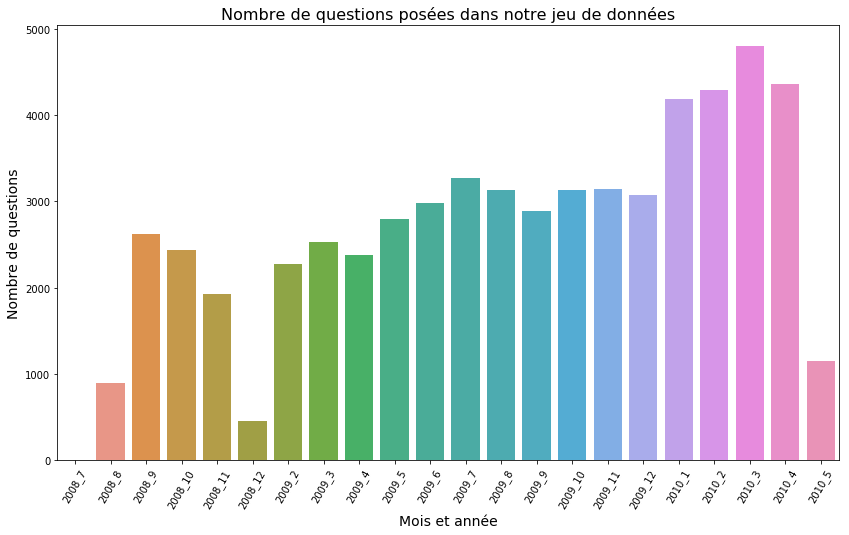

In [55]:
fig = plt.figure(figsize=(14, 8))
dt = table_travail.groupby(by=["Year_Month"])[["Title"]].count()
dt.reset_index(inplace=True)
dt["Year"] = dt["Year_Month"].apply(lambda x: int(x.split("_")[0]))
dt["Month"] = dt["Year_Month"].apply(lambda x: int(x.split("_")[1]))
dt.sort_values(by=["Year","Month"], inplace=True)
sns.barplot(x="Year_Month", y="Title", 
            data=dt, order=list(dt["Year_Month"]))
plt.xlabel("Mois et année", fontsize=14)
plt.ylabel("Nombre de questions", fontsize=14)
plt.xticks(rotation=60)
plt.title("Nombre de questions posées dans notre jeu de données", fontsize=16)
plt.show()

** Figure 001 ** : Répartition des questions de notre jeu de données en fonction de la date de création.

### Exploration de la feature Title : ###

Nous allons nous intéresser au mots les plus fréquents contenus dans la feature Titre.

In [118]:
bow_title = [y for x in table_travail["Title"] for y in aux.tokenizer_idf(x)]
f_dist_title = nltk.FreqDist(bow_title)
dist_title = [sum(f_dist_title.freq(x) for (x,_) 
                  in f_dist_title.most_common(z)) for z in range(80)]

In [117]:
print(f"Nombre de mots contenus dans la feature Title : {len(bow_title)} mots.") 

Nombre de mots contenus dans la feature Title : 198115 mots.


In [118]:
print(f"Richesse lexicale : {round(len(f_dist_title)/len(bow_title)*100,2)} %, soit {len(f_dist_title)} mots uniques.")

Richesse lexicale : 5.99 %, soit 11858 mots uniques.


C:\Users\BIENVENUE\Python\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


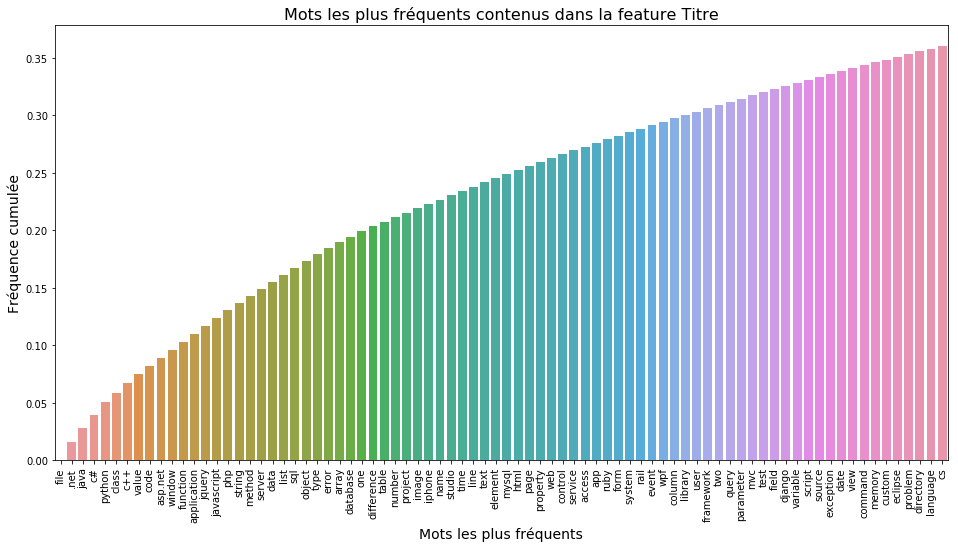

In [115]:
fig = plt.figure(figsize=(16, 8))

df = pd.DataFrame(columns=["% cumulé","mots"])
df["mots"] = [x for (x,_) in f_dist_title.most_common(80)]
df["% cumulé"] = dist_title

sns.barplot(y="% cumulé", x="mots",
            data=df, order=list(df["mots"]))

plt.xlabel("Mots les plus fréquents", fontsize=14)
plt.ylabel("Fréquence cumulée", fontsize=14)
plt.xticks(rotation=90)
plt.title("Mots les plus fréquents contenus dans la feature Titre", fontsize=16)
plt.show()

** Figure 002: ** Fréquence cumulée des mots les plus fréquents contenus dans la feature Titre.

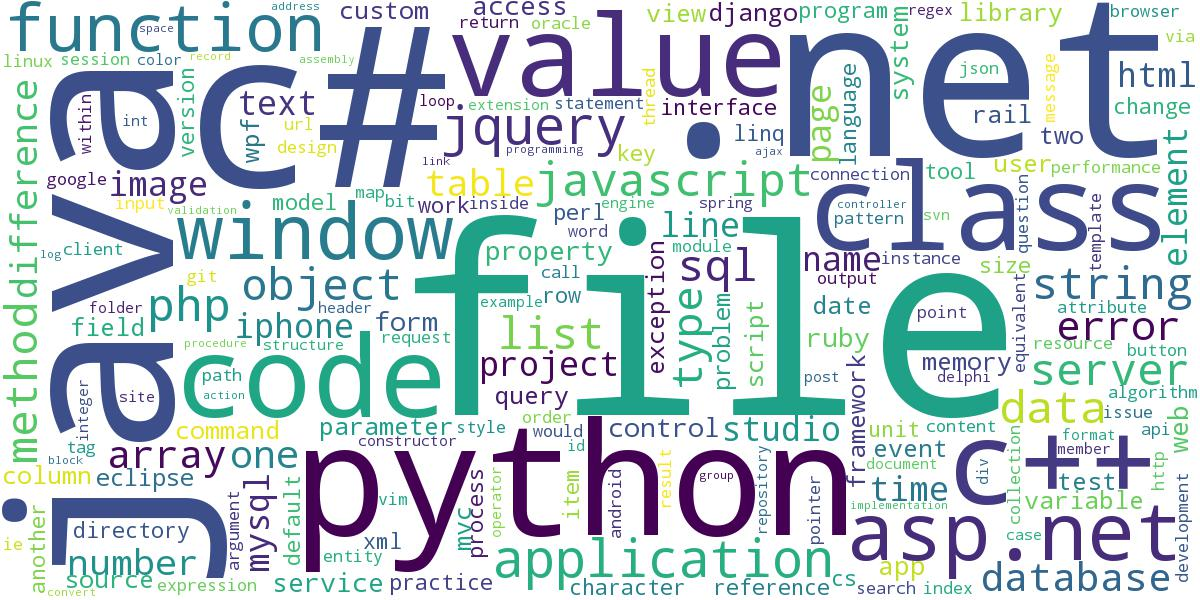

In [119]:
wc = WordCloud(width=1200, height=600, background_color='white', 
               stopwords=None).generate_from_frequencies(f_dist_title)
image = wc.to_file("wordcloud_title.jpg")
display(Image(filename='wordcloud_title.jpg', width=800, 
              height=400, unconfined=True))

** Figure 003: ** Wordcloud representation des mots les plus fréquents contenus dans le titre des questions : File, java, python

### Exploration de la feature Body : ###

Nous allons explorer les mots les plus fréquents contenus dans la feature Body.

In [120]:
bow_body = [y for x in table_travail["Body"] for y in aux.tokenizer_idf(x)]
f_dist_body = nltk.FreqDist(bow_body)

In [124]:
dist_body = [sum(f_dist_body.freq(x) for (x,_) 
                  in f_dist_body.most_common(z)) for z in range(80)]

In [128]:
print(f"Nombre de mots contenus dans la feature Title : {len(bow_body)} mots.")

Nombre de mots contenus dans la feature Title : 2210739 mots.


In [131]:
print(f"Richesse lexicale : {round(len(f_dist_body)/len(bow_body)*100,2)} %, soit {len(f_dist_body)} mots uniques.")

Richesse lexicale : 3.71 %, soit 82050 mots uniques.


C:\Users\BIENVENUE\Python\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


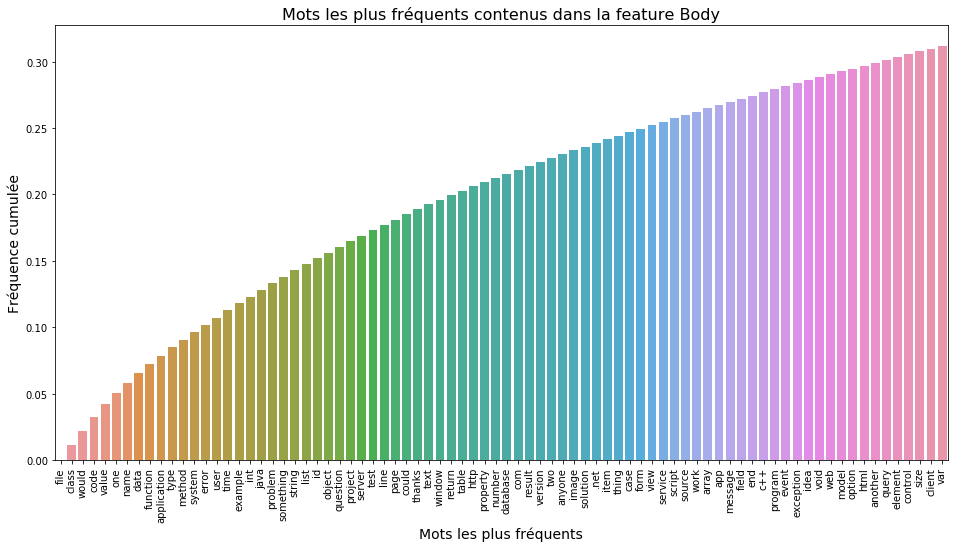

In [125]:
fig = plt.figure(figsize=(16, 8))
df = pd.DataFrame(columns=["% cumulé", "mots"])
df["mots"] = [x for (x, _) in f_dist_body.most_common(80)]
df["% cumulé"] = dist_body

sns.barplot(y="% cumulé", x="mots",
            data=df, order=list(df["mots"]))

plt.xlabel("Mots les plus fréquents", fontsize=14)
plt.ylabel("Fréquence cumulée", fontsize=14)
plt.xticks(rotation=90)
plt.title("Mots les plus fréquents contenus dans la feature Body", fontsize=16)
plt.show()

** Figure 004: ** Fréquence cumulée des mots les plus fréquents contenus dans la feature Body.

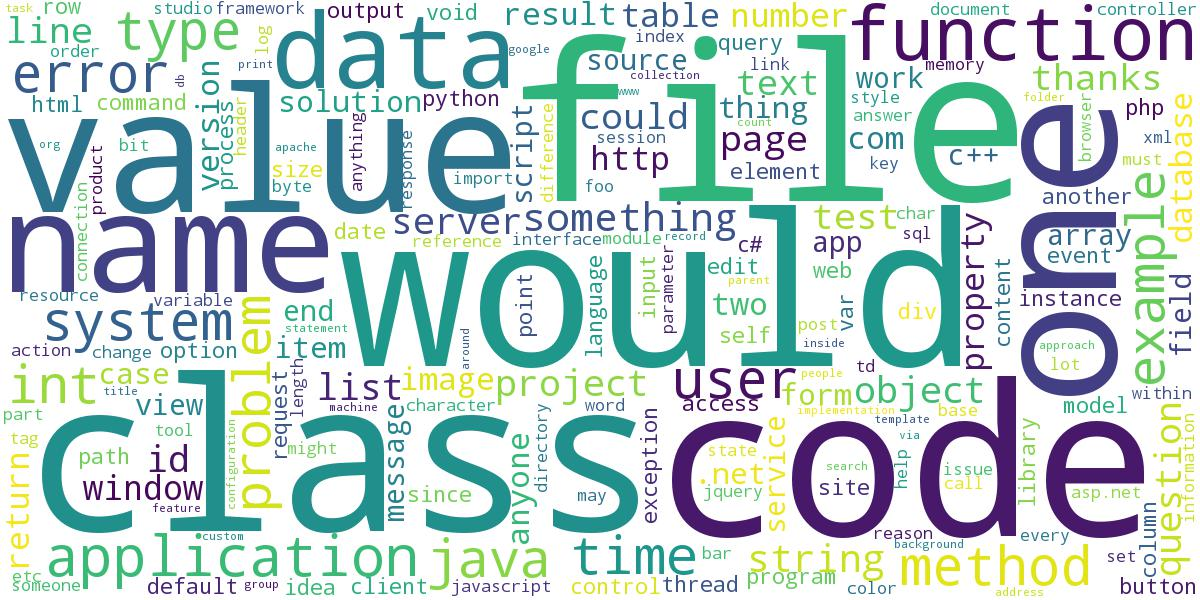

In [126]:
wc = WordCloud(width=1200, height=600, 
               background_color='white').generate_from_frequencies(f_dist_body)
image = wc.to_file("wordcloud_body.jpg")
display(Image(filename='wordcloud_body.jpg', 
              width=800, height=400, unconfined=True))

** Figure 005: ** Wordcloud representation des mots les plus fréquents contenus dans le corps des questions : ....

## Exploration de la feature Tags : ##

Nous allons de même explorer les tags les plus fréquents contenus dans le feature Tags.

In [121]:
bow_tags = [y for x in table_travail["Tags"] for y in x]
f_dist_tags = nltk.FreqDist(bow_tags)
print(f" Nombre de mots contenus dans la feature Tags :{len(bow_tags)} mots.")
print(f" Richesse lexicale : {round(len(f_dist_tags)/len(bow_tags)*100,2)} %, soit {len(f_dist_tags)} uniques.")

 Nombre de mots contenus dans la feature Tags :174895 mots.
 Richesse lexicale : 6.17 %, soit 10797 uniques.


In [4]:
dist_tags = [sum(f_dist_tags.freq(x) for (x,_) 
                  in f_dist_tags.most_common(z)) for z in range(80)]

C:\Users\BIENVENUE\Python\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


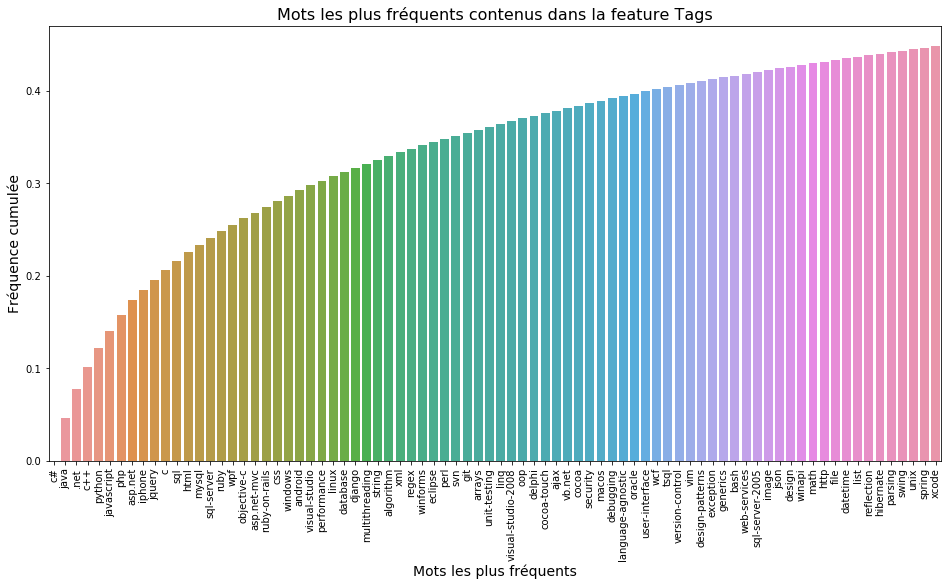

In [5]:
fig = plt.figure(figsize=(16, 8))
df = pd.DataFrame(columns=["% cumulé", "mots"])
df["mots"] = [x for (x, _) in f_dist_tags.most_common(80)]
df["% cumulé"] = dist_tags

sns.barplot(y="% cumulé", x="mots",
            data=df, order=list(df["mots"]))

plt.xlabel("Mots les plus fréquents", fontsize=14)
plt.ylabel("Fréquence cumulée", fontsize=14)
plt.xticks(rotation=90)
plt.title("Mots les plus fréquents contenus dans la feature Tags", fontsize=16)
plt.show()

** Figure 006: ** Fréquence cumulée des mots les plus fréquents contenus dans la feature Tags.

In [116]:
df2 = pd.DataFrame(index=list(dict(f_dist_tags).keys()), 
                   data=list(dict(f_dist_tags).values()), columns=["Frequence"])

list_valeur=list()
valeur = [1, 5, 10, 50, 100, 260, 500, 1000, 10000]
df_valeur=pd.DataFrame(columns=valeur)

for i in valeur:
    df_valeur[i] = df2[df2["Frequence"]> i].count()
    
df_valeur

,1,5,10,50,100,260,500,1000,10000
Frequence,6398,2803,1752,482,256,80,42,22,0


** Figure 007: ** Nombre de tags présent dans au moins 1 à 10000 questions.

C:\Users\BIENVENUE\Python\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


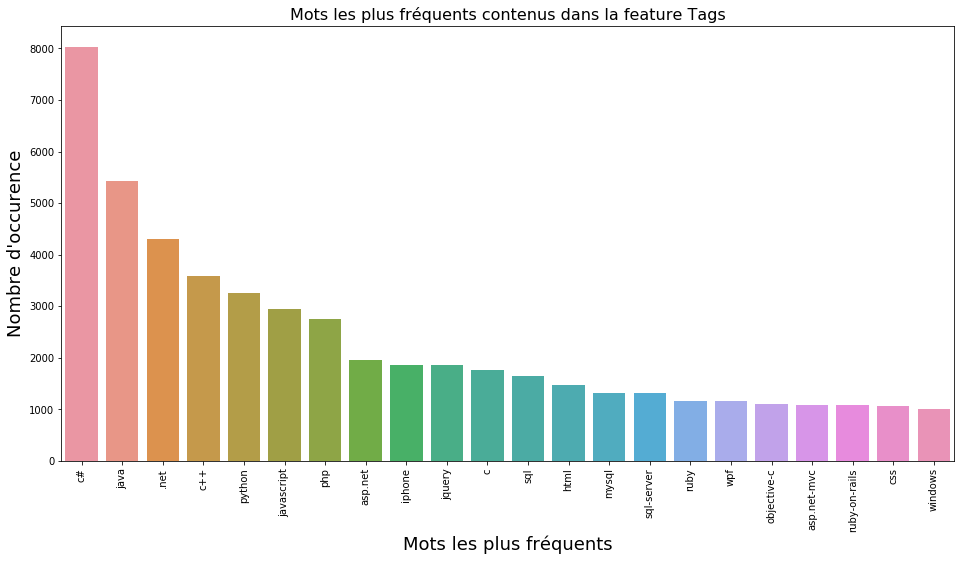

In [134]:
fig = plt.figure(figsize=(16, 8))
df = pd.DataFrame(columns=["% cumulé", "mots","Freq"])
df["mots"] = [x for (x, _) in f_dist_tags.most_common(22)]
#df["% cumulé"] = dist_tags
df["Freq"] = [y for (_, y) in f_dist_tags.most_common(22)]

sns.barplot(y="Freq", x="mots",
            data=df, order=list(df["mots"]))

plt.xlabel("Mots les plus fréquents", fontsize=18)
plt.ylabel("Nombre d'occurence", fontsize=18)
plt.xticks(rotation=90)
plt.title("Mots les plus fréquents contenus dans la feature Tags", fontsize=16)
plt.show()

** Figure 08: ** Représentation des 22 tags le plus fréquents.

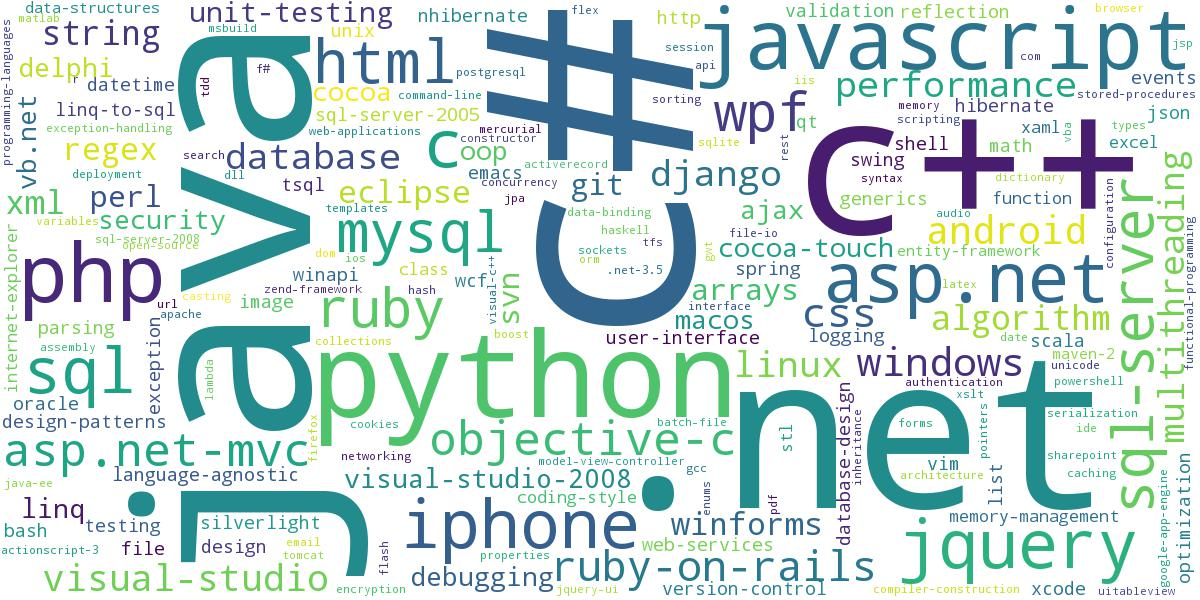

In [135]:
wc = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(f_dist_tags)
image = wc.to_file("wordcloud_tags.jpg")
display(Image(filename='wordcloud_tags.jpg', width=800, height=400, unconfined=True))

** Figure 009: ** Wordcloud representation des mots les plus fréquents contenus dans la feature Tags.

In [128]:
stat1 = len(set(f_dist_title) & set(f_dist_tags)) / len(set(f_dist_tags))
print(f"{round(stat1*100, 2)} % des tags sont présents dans le vocabulaire du titre")

40.44 % des tags sont présents dans le vocabulaire du titre


In [131]:
stat2 = len(set(f_dist_title) & set(f_dist_tags)) / len(set(f_dist_title))
print(f"Les mots de tags présent dans le titre représentent {round(stat2*100, 2)} % de son vocabulaire")

Les mots de tags présent dans le titre représentent 36.82 % de son vocabulaire


In [132]:
stat3 = len(set(f_dist_body) & set(f_dist_tags)) / len(set(f_dist_tags))
print(f"{round(stat3*100, 2)} % des tags sont présents dans le vocabulaire de Body")

49.85 % des tags sont présents dans le vocabulaire de Body


In [133]:
stat4 = len(set(f_dist_body) & set(f_dist_tags)) / len(set(f_dist_body))
print(f"Les mots de tag présents dans Body représentent {round(stat4*100, 2)} % de son vocabulaire")

Les mots de tag présents dans Body représentent 6.56 % de son vocabulaire


## Enregistrement de notre tableau de travail pour la partie modélization : ##

In [139]:
table_travail.to_json("table_model.json")